<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C7/C7.html"><img src="../data/C7_nav.png" width="100"  style="float:right;" alt="C7"></a>
<h1>Feature Design (Chroma, CENS)</h1> 
</div>

<br/>

<p>
Following Section 7.2.1 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we discuss in this notebook a chroma feature variant called CENS. These features were introduced by Müller et al. and successfully applied for audio matching applications.
    
<ul>
    
<!--<li><span style="color:black">
Meinard Müller, Frank Kurth, and Michael Clausen: <strong><a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2005_MuellerKurthClausen_AudioMatching_ISMIR.pdf">Audio Matching via Chroma-Based Statistical Features.</a></strong> Proceedings of the International Conference on Music Information Retrieval (ISMIR), London, UK, pp. 288&ndash;295, 2005.
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_MuellerKC05_ChromaFeatures_ISMIR.txt"> Bibtex </a>
</span></li>
-->
    
<li><span style="color:black">
Meinard Müller, Frank Kurth, and Michael Clausen: <strong><a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2005_MuellerKurthClausen_ChromaAudioFeatures_WASPAA.pdf">Chroma-Based Statistical Audio Features for Audio Matching.</a></strong> Proceedings of the Workshop on Applications of Signal Processing (WASPAA), USA, 275&ndash;278, 2005. 
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_MuellerKC05_ChromaFeatures_WASPAA.txt"> Bibtex </a>
</span></li>    
    
<li><span style="color:black">
Meinard Müller and Sebastian Ewert: <strong><a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2011_MuellerEwert_ChromaToolbox_ISMIR.pdf">Chroma Toolbox: MATLAB implementations for extracting variants of chroma-based audio features.</a></strong> Proceedings of the International Conference on Music Information Retrieval (ISMIR), Miami, Florida, USA, pp. 215–220, 2011.
<br>
 <a href="https://www.audiolabs-erlangen.de/resources/MIR/chromatoolbox">Website of the Chroma Toolbox.</a>
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_MuellerEwert11_ChromaToolbox_ISMIR.txt"> Bibtex </a>
</span></li>
</ul>    
</p> 

## Introduction

Thinking of different performances of the same musical work, all these versions are based on more or less the same note material. The same melodies are played within the same harmonic context.  As we have seen in the [music synchronization scenario](../C3/C3.html) (see Chapter 3 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>), [**chroma-based audio features**](../C3/C3S1_SpecLogFreq-Chromagram.html) are suitable mid-level representations for capturing this kind of information. Recall that chroma features are based on the twelve pitch spelling attributes $\mathrm{C}$, $\mathrm{C}^\sharp$, $\mathrm{D}$, $\ldots$, $\mathrm{B}$ as used in Western music notation, where each chroma vector indicates how the energy in a signal's frame is distributed across the twelve chroma bands. Measuring such distributions over time yields a time&ndash;chroma representation (or **chromagram**) that closely correlates to the melodic and harmonic progression. Such progressions are often similar for different recordings of the same piece of music, thus making chroma features a suitable tool for [content-based retrieval tasks](../C7/C7_ContentBasedAudioRetrieval.html) such as [audio matching](../C7/C7S2_AudioMatching.html) or [version identification](../C7/C7S3_VersionIdentification.html).

We have already seen in Section 3.1.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a> that there are different ways of computing chroma features and that the properties of chroma features can be adjusted by applying suitable postprocessing steps such as [logarithmic compression](../C3/C3S1_LogCompression.html), [normalization](../C3/C3S1_FeatureNormalization.html), or [smoothing](../C3/C3S1_FeatureSmoothing.html). To illustrate this, let us consider two different recordings of the beginning of Beethoven's Fifth Symphony (shown here as a piano-reduced score). One performance (21 seconds) is conducted by Bernstein and the other one (18 seconds) by Karajan. In the code cell, we generate a [basic chroma variant](../C3/C3S1_SpecLogFreq-Chromagram.html) for the Bernstein as well as the Karajan recording using a feature rate of $10~\mathrm{Hz}$, where each chroma vector corresponds to a window of $200~\mathrm{msec}$ with a window overlap of half the size.

<img src="../data/C7/FMP_C7_Audio_Beethoven_Op067-01-001-021_Sibelius-Piano.png" width="900px" align="middle" alt="C3">

<br clear="all" />

<audio src="../data/C7/FMP_C7_Audio_Beethoven_Op067-01-001-021_Bernstein.mp3" type="audio/mpeg" controls="controls"></audio>
<audio src="../data/C7/FMP_C7_Audio_Beethoven_Op067-01-001-021_Karajan.mp3" type="audio/mpeg" controls="controls"></audio>

<!--<img src="../data/C7/FMP_C7_F10a-b.png" width="500px" align="middle" alt="FMP_C7_F10a-b.png">-->

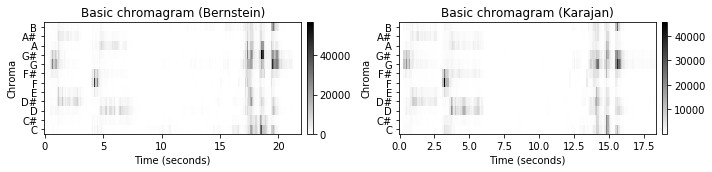

In [1]:
import os
import sys
import numpy as np
import librosa
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sys.path.append('..')
import LibFMP.B
import LibFMP.C3
%matplotlib inline

def plot_two_chromagrams(C1, C2, Fs1=1, Fs2=1, title1='', title2='', figsize=(10, 2.5), clim=None):
    plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, 2)
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], width_ratios=[1, 0.02], wspace=0.05)
    gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1], width_ratios=[1, 0.02], wspace=0.05)
    ax1, ax2, ax3, ax4 = plt.subplot(gs1[0]), plt.subplot(gs1[1]), plt.subplot(gs2[0]), plt.subplot(gs2[1])
    
    LibFMP.B.plot_chromagram(C1, Fs1, ax=[ax1, ax2], clim=clim, title=title1)
    LibFMP.B.plot_chromagram(C2, Fs2, ax=[ax3, ax4], clim=clim, title=title2)
    
    plt.tight_layout()
    plt.show()

fn1 = os.path.join('..', 'data', 'C7', 'FMP_C7_Audio_Beethoven_Op067-01-001-021_Bernstein.wav')
fn2 = os.path.join('..', 'data', 'C7', 'FMP_C7_Audio_Beethoven_Op067-01-001-021_Karajan.wav')
Fs = 22050
x1, Fs = librosa.load(fn1, sr=Fs)
x2, Fs = librosa.load(fn2, sr=Fs)

N = 4410
H = 2205
C1 = librosa.feature.chroma_stft(y=x1, sr=Fs, tuning=0, norm=None, hop_length=H, n_fft=N)
C2 = librosa.feature.chroma_stft(y=x2, sr=Fs, tuning=0, norm=None, hop_length=H, n_fft=N)
Fs1 = Fs / H
Fs2 = Fs / H

title1='Basic chromagram (Bernstein)'
title2='Basic chromagram (Karajan)'
plot_two_chromagrams(C1, C2, Fs1=Fs1, Fs2=Fs2, title1=title1, title2=title2)

To balance out the huge differences in dynamics within and across the recordings, one can apply [normalization techniques](../C3/C3S1_FeatureNormalization.html). For example, one may normalize each chroma vector with regard to the Euclidean norm ($\ell_2$-norm). The result of such a normalization is illustrated by the next figure, where we use two implementations (`librosa.feature.chroma` and `LibFMP.C3.normalize_feature_sequence`) for the normalization. 

<!--<img src="../data/C7/FMP_C7_F10c-d.png" width="500px" align="middle" alt="FMP_C7_F10d-d.png">-->

=== Normalization using librosa.feature.chroma ===


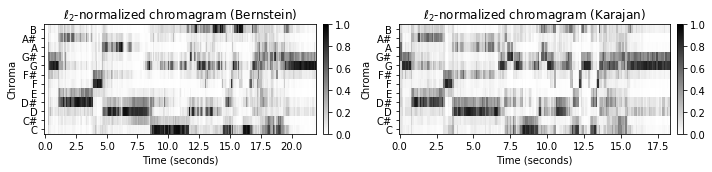

=== Normalization using LibFMP.C3.normalize_feature_sequence ===


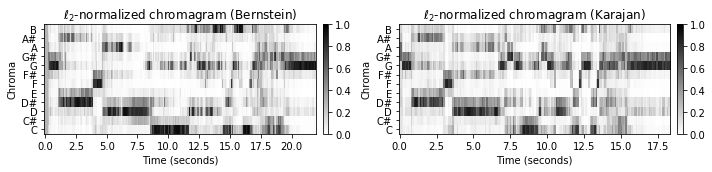

In [2]:
print('=== Normalization using librosa.feature.chroma ===')
C1_norm_LR = librosa.feature.chroma_stft(y=x1, sr=Fs, tuning=0, norm=2, hop_length=H, n_fft=N)
C2_norm_LR = librosa.feature.chroma_stft(y=x2, sr=Fs, tuning=0, norm=2, hop_length=H, n_fft=N)
title1 = r'$\ell_2$-normalized chromagram (Bernstein)'
title2 = r'$\ell_2$-normalized chromagram (Karajan)'
plot_two_chromagrams(C1_norm_LR, C2_norm_LR, Fs1=Fs1, Fs2=Fs2, title1=title1, title2=title2, clim=[0, 1])

print('=== Normalization using LibFMP.C3.normalize_feature_sequence ===')
threshold = 0.0001
C1_norm = LibFMP.C3.normalize_feature_sequence(C1, norm='2', threshold=threshold)
C2_norm = LibFMP.C3.normalize_feature_sequence(C2, norm='2', threshold=threshold)
plot_two_chromagrams(C1_norm, C2_norm, Fs1=Fs1, Fs2=Fs2, title1=title1, title2=title2, clim=[0, 1])

## Quantization

Even though these normalized chromagram representations already reveal similar patterns across the two recordings, there are still many performance-specific differences. Therefore, one idea is to apply additional quantization and smoothing procedures to further reduce the effect of local fluctuations due to variations in local tempo, articulation, and note execution. We now discuss a concrete postprocessing procedure as originally suggested in <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2005_MuellerKurthClausen_AudioMatching_ISMIR.pdf">[Müller et al., ISMIR 2005]</a>, which illustrates how these steps may be implemented in practice. We start with the [basic chroma variant](../C3/C3S1_SpecLogFreq-Chromagram.html) as computed above and normalize each chroma vector with respect to the [Manhattan norm](../C3/C3S1_FeatureNormalization.html) ($\ell^1$-norm) so that the twelve chroma values add up to one. Let $X=(x_1,x_2,\ldots,x_N)$ denote the resulting sequence of normalized chroma vectors $x_n\in[0,1]^{12}$, $n\in[1:N]$. Note that each of these vectors has only positive entries between zero and one. Next, we define a quantization function $Q:[0,1]\to\{0,1,2,3,4\}$ by

\begin{equation}
    Q(a):=\left\{\begin{array}{llrcl}
    0 & \text{ for } & 0    & \leq \,\, a\,\, < &0.05, \\
    1 & \text{ for } & 0.05 & \leq \,\, a\,\, < &0.1, \\
    2 & \text{ for } & 0.1  & \leq \,\, a\,\, < &0.2, \\
    3 & \text{ for } & 0.2  & \leq \,\, a\,\, < &0.4, \\
    4 & \text{ for } & 0.4  & \leq \,\, a\,\, \leq &1. \\
    \end{array}\right.
\end{equation}

In the first step, we quantize each chroma vector $x_n=(x_n(0),\ldots,x_n(11))^\top\in[0,1]^{12}$ by applying $Q$ to each component of $x_n$, yielding

\begin{equation}
Q(x_n):=(Q(x_n(0)),\ldots,Q(x_n(11)))^\top.
\end{equation}

Intuitively, this quantization assigns a value of $4$ to a chroma component if the corresponding chroma class contains more than $40\,\%$ of the signal's total energy
and so on. The chroma components below a $5\,\%$ threshold are set to zero, which introduces robustness to noise. The thresholds are chosen in a logarithmic fashion to account for the [logarithmic perception of sound intensity](../C1/C1S3_Dynamics.html). For example, the vector $x_n=(0.02,0.5,0.3,0.07,0.11,0,\ldots,0)^\top$ is transformed into the vector $Q(x_n):=(0,4,3,1,2,0,\ldots,0)^\top$. 

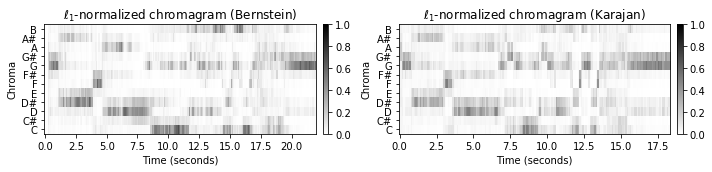

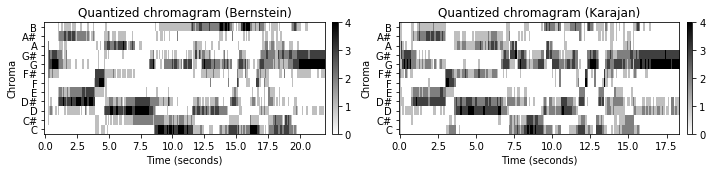

In [3]:
def quantize_matrix(C, quant_fct=None):
    """Quantize matrix values in a logarithmic manner (as done for CENS features)

    Notebook: C7/C7S2_CENS.ipynb

    Args:
        C: Input matrix
        quant_fct: List specifying the quantization function

    Returns:
        C_quant: Output matrix
    """
    C_quant = np.empty_like(C)
    if quant_fct is None:
        quant_fct = [(0.0, 0.05, 0), (0.05, 0.1, 1), (0.1, 0.2, 2), (0.2, 0.4, 3), (0.4, 1, 4)]
    for min_val, max_val, target_val in quant_fct:
        mask = np.logical_and(min_val <= C, C < max_val)
        C_quant[mask] = target_val
    return C_quant

C1 = librosa.feature.chroma_stft(y=x1, sr=Fs, tuning=0, norm=1, hop_length=H, n_fft=N)
C2 = librosa.feature.chroma_stft(y=x2, sr=Fs, tuning=0, norm=1, hop_length=H, n_fft=N)

C1_Q = quantize_matrix(C1)
C2_Q = quantize_matrix(C2)

title1=r'$\ell_1$-normalized chromagram (Bernstein)'
title2=r'$\ell_1$-normalized chromagram (Karajan)'
plot_two_chromagrams(C1, C2, Fs1=Fs1, Fs2=Fs2, title1=title1, title2=title2, clim=[0, 1])

title1='Quantized chromagram (Bernstein)'
title2='Quantized chromagram (Karajan)'
plot_two_chromagrams(C1_Q, C2_Q, Fs1=Fs1, Fs2=Fs2, title1=title1, title2=title2, clim=[0, 4])

## Smoothing and Downsampling

In the second step, the quantized sequence $(Q(x_1),\ldots,Q(x_N))$ is further [smoothed along the temporal dimension](../C3/C3S1_FeatureSmoothing.html). 
To this end, we fix a number $\ell\in\mathbb{N}$ that determines the length of a **smoothing window** (e.g., a Hann window) and then consider local averages (weighted by the window function) of each of the twelve components of the sequence $(Q(x_1),\ldots,Q(x_N))$. This again results in a sequence of $12$-dimensional vectors with nonnegative entries. In the last step, this sequence is **downsampled** by a factor of $d$, and the resulting vectors are normalized with respect to the Euclidean norm ($\ell^2$-norm). The two steps, quantization and smoothing, can be thought of computing weighted statistics of the energy distribution over a window of $\ell$ consecutive vectors. Therefore, we call the resulting features $\mathrm{CENS}^{\ell}_{d}$ (**chroma energy normalized statistics**). In the following code cell, we provide a function that summarizes all steps involved in the CENS feature computation.

The main idea of **CENS** features is that taking statistics over relatively large windows smooths out local deviations in tempo, articulation, and execution of note groups such as trills or arpeggios. As an illustration of this effect, the following example shows the sequences of $\mathrm{CENS}^{41}_{10}$-features for the two Beethoven performances. Starting with a feature rate of $10~\mathrm{Hz}$ for the original chroma sequence, the parameter $\ell=41$ corresponds to a window size of $4100~\mathrm{msec}$. Furthermore, using the downsampling parameter $d=10$ reduces the feature rate to $1~\mathrm{Hz}$ (one feature per second). Compared with the original chroma sequences, the resulting CENS sequences of the two performances possess a much higher degree of similarity, while still capturing some characteristic musical information. 

<!--<img src="../data/C7/FMP_C7_F10e-f.png" width="500px" align="middle" alt="FMP_C7_F10e-f.png">-->

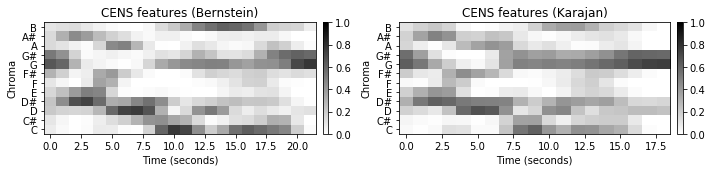

In [4]:
def compute_CENS_from_chromagram(C, Fs=1, ell=41, d=10, quant=True):
    """Compute CENS features from chromagram

    Notebook: C7/C7S2_CENS.ipynb

    Args:
        C: Input chromagram
        Fs: Feature rate of chromagram
        ell: Smoothing length
        d: Downsampling factor
        quant: Apply quantization

    Returns:
        C_CENS: CENS features
        F_CENS: Feature rate of CENS features
    """
    C_norm = LibFMP.C3.normalize_feature_sequence(C, norm='1')
    C_Q = quantize_matrix(C_norm) if quant else C_norm

    C_smooth, Fs_CENS = LibFMP.C3.smooth_downsample_feature_sequence(C_Q, Fs, filt_len=ell,
                                                                     down_sampling=d, w_type='hann')
    C_CENS = LibFMP.C3.normalize_feature_sequence(C_smooth, norm='2')

    return C_CENS, Fs_CENS

C1 = librosa.feature.chroma_stft(y=x1, sr=Fs, tuning=0, norm=1, hop_length=H, n_fft=N)
C2 = librosa.feature.chroma_stft(y=x2, sr=Fs, tuning=0, norm=1, hop_length=H, n_fft=N)

C1_CENS, Fs1_CENS = compute_CENS_from_chromagram(C1, Fs1)
C2_CENS, Fs2_CENS = compute_CENS_from_chromagram(C2, Fs2)

title1='CENS features (Bernstein)'
title2='CENS features (Karajan)'
plot_two_chromagrams(C1_CENS, C2_CENS, Fs1=Fs1_CENS, Fs2=Fs2_CENS, title1=title1, title2=title2, clim=[0, 1])

## Parameter Settings

The CENS concept yields a family of chroma features $\mathrm{CENS}^{\ell}_{d}$ depending on the two main parameters $\ell\in\mathbb{N}$ and $d\in\mathbb{N}$. The described procedure provides a computationally inexpensive way to adjust the feature specificity and resolution without repeating the cost-intensive computation of the original chromagram. In the following figure, we show some CENS feature representations using different smoothing and downsampling parameters. 

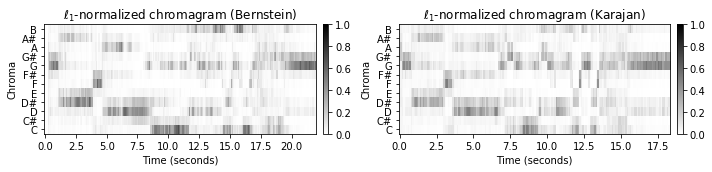

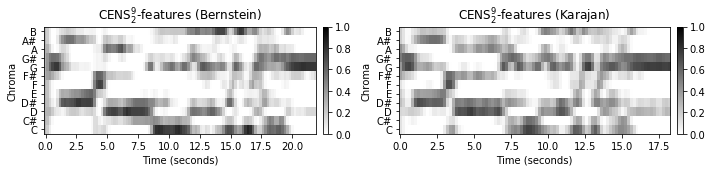

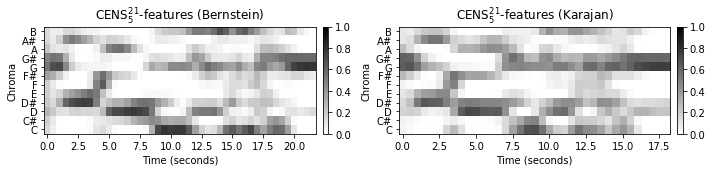

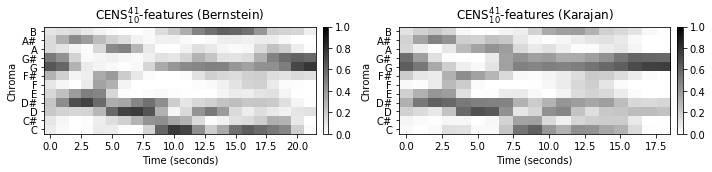

In [5]:
title1=r'$\ell_1$-normalized chromagram (Bernstein)'
title2=r'$\ell_1$-normalized chromagram (Karajan)'
plot_two_chromagrams(C1, C2, Fs1=Fs1, Fs2=Fs2, title1=title1, title2=title2, clim=[0, 1])

parameter_set = [(9, 2), (21, 5), (41, 10)]
for parameter in parameter_set:
    ell = parameter[0]
    d = parameter[1]
    C1_CENS, Fs1_CENS = compute_CENS_from_chromagram(C1, Fs1, ell=ell, d=d)
    C2_CENS, Fs2_CENS = compute_CENS_from_chromagram(C2, Fs2, ell=ell, d=d)
    title1=r'CENS$^{%d}_{%d}$-features (Bernstein)' % (ell, d)
    title2=r'CENS$^{%d}_{%d}$-features (Karajan)' % (ell, d)
    plot_two_chromagrams(C1_CENS, C2_CENS, Fs1=Fs1_CENS, Fs2=Fs2_CENS,
                         title1=title1, title2=title2, clim=[0, 1])

## Further Notes

CENS features can be computed starting with any chromagram representation. For example, instead of using an STFT-based chromagram, one may start with a chromagrams based on a **multirate filter bank**. Such an approach was used in the original <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2005_MuellerKurthClausen_ChromaAudioFeatures_WASPAA.pdf">CENS publication</a>. The following figure summarizes the overall CENS computation as introduced in the original paper. 

<br clear="all" />
<img src="../data/C7/FMP_C7S3_CENS_WASPAA.png" width="700px" align="left" alt="C7_CENS">
<br clear="all" />

The library <a href="https://librosa.github.io/">LibROSA</a> also contains a function (`librosa.feature.chroma_cens`) to compute CENS features. The downsampling needs to be done outside that function (e.g., using `C_CENS[:, ::d]`).

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and <a href="https://www.audiolabs-erlangen.de/fau/assistant/zalkow">Frank Zalkow</a>.
</div>  


<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>